In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

In [2]:
def findFiles(path):
    return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters) + 1 # EOL marker

def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("names/data/names/*.txt"):
    category = filename.split("/")[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_categories):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size + n_categories, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.softmax = nn.LogSoftmax()
        
    def init_hidden(self):
        return (
            Variable(torch.zeros(1, 1, self.hidden_size)),
            Variable(torch.zeros(1, 1, self.hidden_size))
        )
    
    def forward(self, category, data):
        input_combined = torch.cat((category, data), 1).unsqueeze(0)
        lstm_out, self.hidden = self.lstm(input_combined, self.hidden)
        result = self.linear(lstm_out.view(len(data), -1))
        result = self.softmax(result)
        return result

In [4]:
import random

def random_choice(l):
    return l[random.randint(0, len(l)-1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [5]:
def get_category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def get_input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def get_target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOL
    return torch.LongTensor(letter_indexes)


In [6]:
def random_training_example():
    category, line = random_training_pair()
    category_tensor = Variable(get_category_tensor(category))
    input_line_tensor = Variable(get_input_tensor(line))
    target_line_tensor = Variable(get_target_tensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [31]:
criterion = nn.NLLLoss()

learning_rate = 0.001

rnn = RNN(n_letters, 128, n_letters, n_categories)

def train(category_tensor, input_line_tensor, target_line_tensor):
    rnn.hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output = rnn(category_tensor, input_line_tensor[i])
        loss += criterion(output, target_line_tensor[i])
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.data[0] / input_line_tensor.size()[0]

In [32]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [33]:
n_iters = 1000000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


1m 23s (5000 0%) 2.5930
2m 43s (10000 1%) 2.5644


KeyboardInterrupt: 

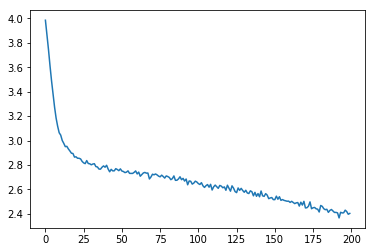

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

In [24]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    category_tensor = Variable(get_category_tensor(category))
    data = Variable(get_input_tensor(start_letter))
    rnn.hidden = rnn.init_hidden()

    output_name = start_letter

    for i in range(max_length):
        output = rnn(category_tensor, data[0])
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        data = Variable(get_input_tensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [30]:
samples("English", "ABCSD")

Aaner
Baner
Caner
Saner
Daner
